In [1]:
%pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch-lr-finder


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch #for using tensors and any computations
import torch.nn as nn # used to build neural networks (layers, loss functions)
import torch.optim as optim #optim algos
from torch.utils.data import DataLoader#loads data in batches and shuffles them
from dataset import ClipDataset #custom dataset class for loading in the ds to the model
from model import build_model_r3d_18 #function that defines the model
from model import build_model_mc3
from torch_lr_finder import LRFinder #finds a good lr to use for model updates
import matplotlib.pyplot as plt
from datetime import datetime
import os

/home/atupulazi/personal_projects/collision-detection/.venv/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
# Set Device -> Load data -> Build Model -> pick loss/optimizer -> Train Loop -> Evaluate -> Save

In [5]:
#Setting the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Example Training Loop Explanation
# outputs = model(clips)               # model makes guesses
# loss = criterion(outputs, labels)    # "someone" tells how wrong the guesses were
# loss.backward()                      # model feels the pain and learns
# optimizer.step()                     # weights are updated based on the feedback

# The loss function is like your teacher saying:
#    "You got 5 out of 8 wrong — here's how wrong you were and how much to adjust."

In [7]:
# Define and Load Dataset

train_dataset = ClipDataset(csv_path="/home/atupulazi/personal_projects/collision-detection/frames/train/train_clip_labels.csv", split='train')
val_dataset = ClipDataset(csv_path="/home/atupulazi/personal_projects/collision-detection/frames/val/val_clip_labels.csv", split='val')

# batch_size is how many samples are passed into the model before the weights are updated
    # You look at 8 clips at once, guess all of them, then someone (training loss) tells you how many you got right. 
    # You adjust your understanding based on all 8 at once
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [13]:
# Build Model
model = build_model_mc3()
#model = build_model_r3d_18()
model = model.to(device) # builds the model on the GPU if available or CPU if not

model_name = "mc3_18"
#model_name = "r3d_18"



In [9]:
# Pick Loss and Optimizer

criterion = nn.CrossEntropyLoss()
# model.parameters() are numbers the model can change to improve its performance. Pytorch does this automatically
optimizer = optim.Adam(model.parameters(), lr=0.001)

 73%|███████▎  | 73/100 [00:05<00:02, 12.33it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.15E-01


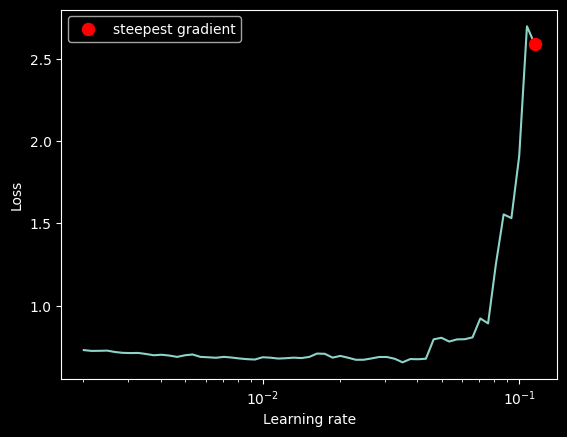

In [10]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=100)  # Try LRs from 1e-7 to 1

# Plot the result
lr_finder.plot()  # This shows you the graph
lr_finder.reset() # Reset model & optimizer to initial state

[Epoch: 1] Train Loss: 0.7675
Epoch: 1 Validation Accuracy:  12.50%
Epoch: 1 Validation Accuracy:  6.25%
Epoch: 1 Validation Accuracy:  8.33%
Epoch: 1 Validation Accuracy:  12.50%
Epoch: 1 Validation Accuracy:  10.00%
Epoch: 1 Validation Accuracy:  8.33%
Epoch: 1 Validation Accuracy:  17.86%
Epoch: 1 Validation Accuracy:  28.12%
Epoch: 1 Validation Accuracy:  36.11%
Epoch: 1 Validation Accuracy:  42.50%
Epoch: 1 Validation Accuracy:  47.73%
Epoch: 1 Validation Accuracy:  51.04%
Epoch: 1 Validation Accuracy:  53.00%
[Epoch: 2] Train Loss: 0.7690
Epoch: 2 Validation Accuracy:  12.50%
Epoch: 2 Validation Accuracy:  6.25%
Epoch: 2 Validation Accuracy:  4.17%
Epoch: 2 Validation Accuracy:  6.25%
Epoch: 2 Validation Accuracy:  5.00%
Epoch: 2 Validation Accuracy:  4.17%
Epoch: 2 Validation Accuracy:  14.29%
Epoch: 2 Validation Accuracy:  25.00%
Epoch: 2 Validation Accuracy:  33.33%
Epoch: 2 Validation Accuracy:  40.00%
Epoch: 2 Validation Accuracy:  45.45%
Epoch: 2 Validation Accuracy:  48.96

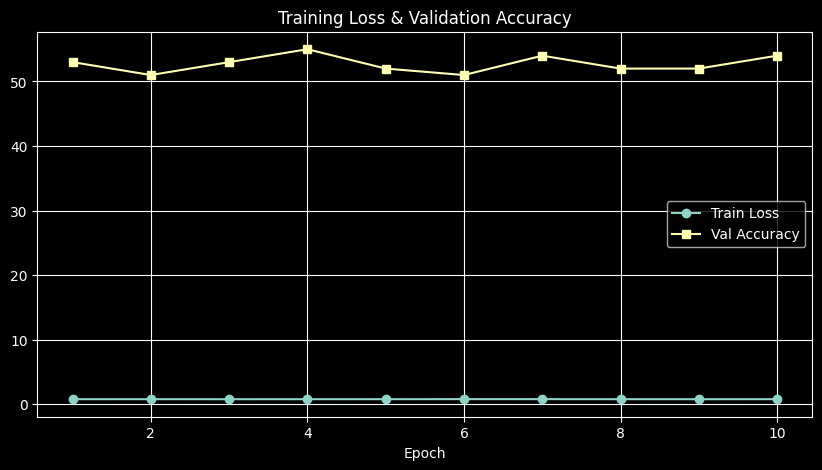

In [ ]:
# Training Loop (Evaluate)

num_of_epochs = 10 # More epochs = more chances to learn from the same data.\
train_losses = []
val_accuracy = []

for epoch in range(num_of_epochs):
    # why? do u need this? exp what exactly it does
    model.train() #  puts layers like dropout/batchnorm in training mode.
    running_loss = 0.0 # Tracks cumulative loss for this epoch.

    for clips, labels in train_loader:
        clips, labels = clips.to(device), labels.to(device)

        optimizer.zero_grad() # reset previous gradients? why?
        outputs = model(clips) # Forward pass? meaning?
        loss = criterion(outputs, labels) # Compute Loss
        loss.backward() # backward pass (compute gradients). is this backprop? 
        optimizer.step() # update weights. how does this update weights? i thought weights updates going forward not backward

        running_loss = running_loss + loss.item() #accumulate loss. what is item? why do we want to accumulate loss?

    avg_loss = running_loss / len(train_loader) # Why are we dividing by the len of train_loader and not by the num of epochs
    train_losses.append(avg_loss)
    print(f"[Epoch: {epoch+1}] Train Loss: {avg_loss:.4f}") #why are we doing +1?

    # Validation Loop

    model.eval() # turns off dropout, batchnorm updates. what are those and why do we turn them off?
    correct_predictions = 0
    total_seen = 0

    with torch.no_grad():
        for clips, labels in val_loader:
            clips, labels = clips.to(device), labels.to(device)
            outputs = model(clips) #forward only, is there another way for backward? like why do we have to specify this
            _, predicted = torch.max(outputs.data, 1) # only get predicted class. what is torch.max? outputs.data? 1?
            total_seen += labels.size(0) #huh??
            correct_predictions += (predicted == labels).sum().item() # i understand that this is checking if the predicted label 
                                                                    # is the sames as the actual labels but why use .sum and .item
            accuracy = 100 * correct_predictions / total_seen # get the accuracy result out of a 100?
            print(f"Epoch: {epoch+1} Validation Accuracy: {accuracy: .2f}%")
        val_accuracy.append(accuracy)

        
    


    

In [ ]:
# ========== Plotting ==========

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs("plots", exist_ok=True)

# Save plot by model name + timestamp (optional for versioning)
plot_filename = f"plots/{model_name}_loss_plot_{timestamp}.png"

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title(f"{model_name.upper()} Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig(plot_filename)
plt.close()


In [15]:
#Save 

#what is being saved exactly?

os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), f"checkpoints/{model_name}.pth")

In [17]:
# Ensure folder exists
os.makedirs("metrics_log", exist_ok=True)

# Build clean filename
filename = f"metrics_log/{model_name}_{timestamp}.csv"

# Check if file exists so you only write header once
write_header = not os.path.exists(filename)

with open(filename, "a") as f:
    if write_header:
        f.write("Epoch,Average Loss,Accuracy\n")
    f.write(f"{epoch+1},{avg_loss:.4f},{accuracy:.2f}\n")


In [ ]:
#Early Stopping if accuracy doesnt improve
# best_accuracy = 0
# if accuracy > best_accuracy:
#     best_accuracy = accuracy
#     torch.save(model.state_dict(), "checkpoints/best_model.pth")
#     patience_counter = 0
# else:
#     patience_counter += 1
#     if patience_counter >= patience_limit:
#         print("Early stopping triggered")
#         break
